# Autores
- Javier Abella
- Victor Teixidó
- Tomás Treviño
- You Wu

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn import set_config
import warnings
set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

#2. Redes neuronales con sentido de la moda


El conjunto de datos Fashion MNIST es un conjunto de datos de referencia creado por Zalando3.

Fue generado para tener un conjunto de datos no tan fácil como otros conjuntos de datos de referencia similares basados en dígitos escritos a mano. En este algunas clases son más difíciles de identificar que otras. El conjunto de datos contiene imágenes de 28×28 en escala de grises de diferentes tipos de ropa, zapatos y bolsos. Vamos a trabajar con un subconjunto de los datos, específicamente con las clases camiseta (0), jersey (2) y camisa (6) y experimentar con clasificación y reducción de dimensionalidad. Utilizaremos keras para implementar las redes neuronales.

## Apartado a

Los resultados serán un conjunto de matrices numpy. Ahora deberéis seleccionar las clases
0, 2 y 6 para los datos de entrenamiento y test. Tendréis que cambiar las etiquetas para
que correspondan a 0, 1 y 2. Normalizad los datos para que estén en el rango [0-1], solo
necesitaréis dividir los datos entre 255. Como podéis ver, la división en entrenamiento y
test ya está hecha.



In [ ]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def preprocessing(X, y):
    print('Tamaño original:{}'.format(X.shape))
    
    # select classes 0, 2 and 6
    indexes = np.where(y==0)[0]
    indexes = np.concatenate((indexes, np.where(y==2)[0]), axis=0)
    indexes = np.concatenate((indexes, np.where(y==6)[0]), axis=0)

    X = np.array([X[i] for i in indexes])
    y = np.array([y[i] for i in indexes])

    # rename classes
    y = np.where(y==0, 0, y)
    y = np.where(y==2, 1, y)
    y = np.where(y==6, 2, y)

    # normalization of the data
    X = X / 255
    
    print('Nuevo tamaño:{}'.format(X.shape))
    return X, y

In [ ]:
X_train, y_train = preprocessing(X_train,y_train)
print()
X_test, y_test = preprocessing(X_test,y_test)

Tamaño original:(60000, 28, 28)
Nuevo tamaño:(18000, 28, 28)

Tamaño original:(10000, 28, 28)
Nuevo tamaño:(3000, 28, 28)


##Apartado b

En este primer apartado vamos a usar un MLP para clasificar los datos.

El primer paso será experimentar con el número de neuronas para las dos capas ocultas, teniendo siempre que NN2 sea menor a NN1. No exploraremos valores muy grandes para evitar posibles over-fitting. Además del número de neuronas, entrenaremos 3 modelos con funcioens de activación distintas: linear, sigmoid y relu.

Para el entrenamiento utilizaremos el optimizador adam y como función de pérdida usaremos la entropía cruzada categórica. Mediremos la función de pérdida durante el entrenamiento junto al acierto. Agregaramos unos datos de test en el parámetro validation_data hace que también se mida función de pérdida con esos datos. Dado que el entrenamiento es bastante costoso, no vamos a hacer validación cruzada y usaremos datos de test para decidir los mejores parámetros.

### Linear activation

Vamos a explorar el número de neuronas para la primera y la segunda capa oculta de nuestra red. Con el método predict, iremos almacenando que ratio de acierto tiene cada uno de los modelos entrenados para al final escoger el que mejor resultados nos proporcione.

In [ ]:
NN1 = [2,4,6,8,10]
NN2 = [1,2,4,6,8]
act = 'linear'

history_info = []
parameters = []
accuracies = []

for x in NN1:
  for y in NN2:
    if y < x:
      input = keras.Input(shape=(28,28))
      model = keras.layers.Flatten()(input)
      model = keras.layers.Dense(x, activation=act)(model)
      model = keras.layers.Dense(y, activation=act)(model)
      model = keras.layers.Dense(3, activation='softmax')(model)
      nn = keras.Model(input, model)

      nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      error = nn.fit(X_train, y_train, epochs=200, verbose=False, validation_data=(X_test, y_test))

      # save history information for current (NN1,NN2)
      history_info.append((error))
      parameters.append([x,y])

      # accuracies of the predictions
      predictions = [np.argmax(x) for x in nn.predict(X_test)]
      accuracies.append(np.sum(np.array(predictions) == np.array(y_test)) / len(y_test))

In [ ]:
# get best parameters
index = np.argmax(accuracies)
linear_NN1, linear_NN2 = parameters[index]

# save the best model
input = keras.Input(shape=(28,28))
model = keras.layers.Flatten()(input)
model = keras.layers.Dense(linear_NN1, activation=act)(model)
model = keras.layers.Dense(linear_NN2, activation=act)(model)
model = keras.layers.Dense(3, activation='softmax')(model)
linear_model = keras.Model(input, model)

linear_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
linear_model.fit(X_train, y_train, epochs=200, verbose=False)

print('\nNN1:', linear_NN1)
print('NN2:', linear_NN2)
print('Accuracy:', accuracies[index])


NN1: 8
NN2: 4
Accuracy: 0.7966666666666666


Podemos ver como el mejor resultado de acierto, entre los modelos explorados, es el que tiene en la primera capa 8 neuronas y en la segunda 4. Con estos parámetros hemos obtenido un acierto de aproximadamente 0.7967.

En cuanto al número de épocas, a partir del mejor modelo que hemos obtenido, nos fijaremos en que el entrenamiento devuelve un objeto que recoge la pérdida y el acierto de cada época. Vamos a representar el acierto del entrenamiento y el test para así decidir qué número de épocas es el más adecuado.

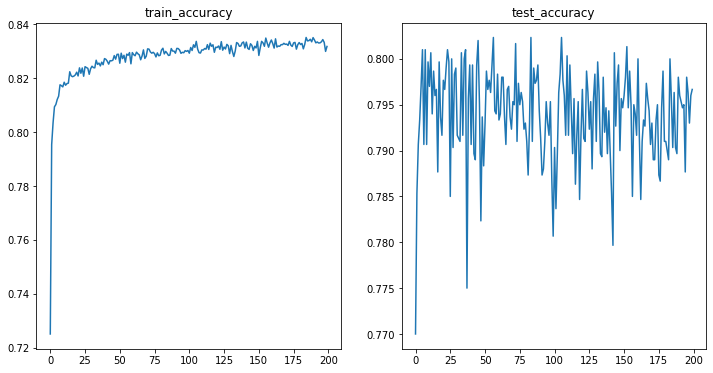

In [ ]:
from matplotlib.pyplot import plot

fig,ax = plt.subplots(1,2,figsize=(12,6))

train_accuracy = history_info[index].history['accuracy']
test_accuracy = history_info[index].history['val_accuracy']

ax[0].plot(train_accuracy);
ax[1].plot(test_accuracy);

ax[0].set_title('train_accuracy');
ax[1].set_title('test_accuracy');

Estos dos gráficos representa la evolución del ratio de acierto para los conjuntos de entrenamiento y test, respectivamente, a medida que el número de épocas aumenta. En el conjunto de entrenamiento, podemos ver como el acierto del modelo va aumentando a la par que el número de épocas aumenta también.

Por otro lado, en el segundo gráfico podemos ver un comportamiento más errático. Se dan picos tanto altos como bajos de ratio de acierto, aún así, como evolución general, se puede observar como los picos superiores parecen ser más pequeños cada vez. Es decir, en este segundo caso, un mayor número de épocas no corresponde en un mejor resultado.

El número de épocas está relacionado también con el problema de over-fitting que se da cuando el número de épocas empieza a ser muy grande. Esta parecer ser la causa del comportamiento que vemos en las gráficas. Es por esto que vemos como el acierto en el conjunto de entrenamiento sigue aumentando mientras que el conjunto test disminuye.

In [ ]:
linear_epochs = np.argmax(history_info[index].history['val_accuracy'])
linear_epochs

56

El número de épocas más adecuado es 56.

In [ ]:
from sklearn.metrics import classification_report

target_names = ["Class {}".format(i) for i in range(3)]

pred = [np.argmax(x) for x in linear_model.predict(X_test)]
print(classification_report(y_test, pred, target_names=target_names))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.79      0.88      0.83      1000
     Class 1       0.84      0.83      0.84      1000
     Class 2       0.74      0.66      0.70      1000

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



Podemos observar que para la función de activación *linear* tenemos aciertos razonablemente buenos. Especialmente respecto a las clases 0 y 1, con aciertos del 0.83 y 0.84 respectivamente. Por otro lado, la clase con la que más se equivoca nuestro modelo es la clase 2 (aunque sigue teniendo un ratio de acierto decente).

Hablando en general de nuestro modelo, podemos ver que obtiene un probabilidad de acierto de aproximadamente 0.79, lo cual podría ser catalogado como bueno.

### Sigmoid activation

Vamos a explorar el número de neuronas para la primera y la segunda capa oculta de nuestra red. Con el método predict, iremos almacenando que ratio de acierto tiene cada uno de los modelos entrenados para al final escoger el que mejor resultados nos proporcione.

In [ ]:
NN1 = [2,4,6,8,10]
NN2 = [1,2,4,6,8]
act = 'sigmoid'

history_info = []
parameters = []
accuracies = []

for x in NN1:
  for y in NN2:
    if y < x:
      input = keras.Input(shape=(28,28))
      model = keras.layers.Flatten()(input)
      model = keras.layers.Dense(x, activation=act)(model)
      model = keras.layers.Dense(y, activation=act)(model)
      model = keras.layers.Dense(3, activation='softmax')(model)
      nn = keras.Model(input, model)

      nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      error = nn.fit(X_train, y_train, epochs=200, verbose=False, validation_data=(X_test, y_test))

      # save history information for current (NN1,NN2)
      history_info.append((error))
      parameters.append([x,y])

      # accuracies of the predictions
      predictions = [np.argmax(x) for x in nn.predict(X_test)]
      accuracies.append(np.sum(np.array(predictions) == np.array(y_test)) / len(y_test))

In [ ]:
# get best parameters
index = np.argmax(accuracies)
sigmoid_NN1, sigmoid_NN2 = parameters[index]

# save the best model
input = keras.Input(shape=(28,28))
model = keras.layers.Flatten()(input)
model = keras.layers.Dense(sigmoid_NN1, activation=act)(model)
model = keras.layers.Dense(sigmoid_NN2, activation=act)(model)
model = keras.layers.Dense(3, activation='softmax')(model)
sigmoid_model = keras.Model(input, model)

sigmoid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
sigmoid_model.fit(X_train, y_train, epochs=200, verbose=False)

print('\nNN1:', sigmoid_NN1)
print('NN2:', sigmoid_NN2)
print('Accuracy:', accuracies[index])


NN1: 10
NN2: 4
Accuracy: 0.8263333333333334


Podemos ver como el mejor resultado de acierto, entre los modelos explorados, es el que tiene en la primera capa 10 neuronas y en la segunda 4. Con estos parámetros hemos obtenido aproximadamente 0.8263 de acierto.

En cuanto al número de épocas, a partir del mejor modelo que hemos obtenido, nos fijaremos en que el entrenamiento devuelve un objeto que recoge la pérdida y el acierto de cada época. Vamos a representar el acierto del entrenamiento y el test para así decidir qué número de épocas es el más adecuado.

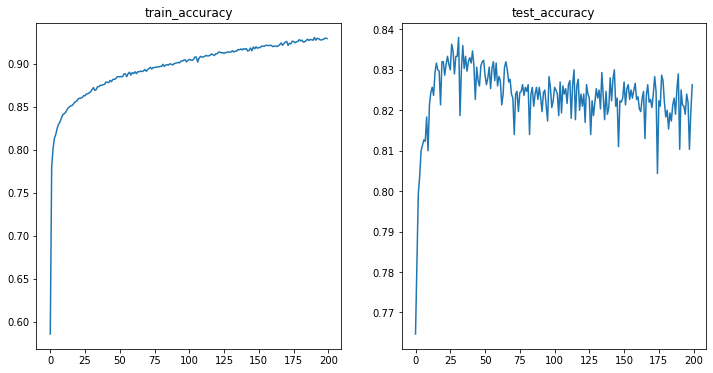

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

train_accuracy = history_info[index].history['accuracy']
test_accuracy = history_info[index].history['val_accuracy']

ax[0].plot(train_accuracy);
ax[1].plot(test_accuracy);

ax[0].set_title('train_accuracy');
ax[1].set_title('test_accuracy');

Estos dos gráficos representa la evolución del ratio de acierto para los conjuntos de entrenamiento y test, respectivamente, a medida que el número de épocas aumenta. En el conjunto de entrenamiento, podemos ver como el acierto del modelo va aumentando a la par que el número de épocas aumenta también.

Por otro lado, y al igual que pasaba con la activación *linear*, en el segundo gráfico podemos ver un comportamiento más errático. Se dan picos tanto altos como bajos de ratio de acierto, aún así, como evolución general, se puede observar como los picos superiores parecen ser más pequeños cada vez. Es decir, en este segundo caso, un mayor número de épocas no corresponde en un mejor resultado.

El número de épocas está relacionado también con el problema de over-fitting que se da cuando el número de épocas empieza a ser muy grande. Esta parecer ser la causa del comportamiento que vemos en las gráficas. Es por esto que vemos como el acierto en el conjunto de entrenamiento sigue aumentando mientras que el conjunto test disminuye.

In [ ]:
sigmoid_epochs = np.argmax(history_info[index].history['val_accuracy'])
sigmoid_epochs

31

El número de épocas más adecuado es 31.

In [ ]:
target_names = ["Class {}".format(i) for i in range(3)]

pred = [np.argmax(x) for x in sigmoid_model.predict(X_test)]
print(classification_report(y_test, pred, target_names=target_names))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.84      0.84      0.84      1000
     Class 1       0.84      0.90      0.87      1000
     Class 2       0.78      0.72      0.75      1000

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



Podemos observar que para la función de activación *sigmoid* tenemos aciertos razonablemente buenos. Especialmente respecto a las clases 0 y 1, con aciertos de 0.84 y 0.9 respectivamente. Por otro lado, la clase con la que más se equivoca nuestro modelo es la clase 2, aunque a pesar de esto sigue teniendo un acierto decente (0.75).

Hablando en general de nuestro modelo, podemos ver que obtiene un ratio de acierto de aproximadamente un 0.82, lo cual podría ser catalogado como un buen modelo.

### Relu activation

Vamos a explorar el número de neuronas para la primera y la segunda capa oculta de nuestra red. Con el método predict, iremos almacenando que ratio de acierto tiene cada uno de los modelos entrenados para al final escoger el que mejor resultados nos proporcione.

In [ ]:
NN1 = [2,4,6,8,10]
NN2 = [1,2,4,6,8]
act = 'relu'

history_info = []
parameters = []
accuracies = []

for x in NN1:
  for y in NN2:
    if y < x:
      input = keras.Input(shape=(28,28))
      model = keras.layers.Flatten()(input)
      model = keras.layers.Dense(x, activation=act)(model)
      model = keras.layers.Dense(y, activation=act)(model)
      model = keras.layers.Dense(3, activation='softmax')(model)
      nn = keras.Model(input, model)

      nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      error = nn.fit(X_train, y_train, epochs=200, verbose=False, validation_data=(X_test, y_test))

      # save history information for current (NN1,NN2)
      history_info.append((error))
      parameters.append([x,y])

      # accuracies of the predictions
      predictions = [np.argmax(x) for x in nn.predict(X_test)]
      accuracies.append(np.sum(np.array(predictions) == np.array(y_test)) / len(y_test))

In [ ]:
# get best parameters
index = np.argmax(accuracies)
relu_NN1, relu_NN2 = parameters[index]

# save the best model
input = keras.Input(shape=(28,28))
model = keras.layers.Flatten()(input)
model = keras.layers.Dense(relu_NN1, activation=act)(model)
model = keras.layers.Dense(relu_NN2, activation=act)(model)
model = keras.layers.Dense(3, activation='softmax')(model)
relu_model = keras.Model(input, model);

relu_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']);
relu_model.fit(X_train, y_train, epochs=200, verbose=False);

print('\nNN1:', relu_NN1)
print('NN2:', relu_NN2)
print('Accuracy:', accuracies[index])


NN1: 10
NN2: 1
Accuracy: 0.815


Podemos ver como el mejor resultado de acierto, entre los modelos explorados, es el que tiene en la primera capa 10 neuronas y en la segunda 1. Con estos parámetros hemos obtenido un 0.815 de acierto.

En cuanto al número de épocas, a partir del mejor modelo que hemos obtenido, nos fijaremos en que el entrenamiento devuelve un objeto que recoge la pérdida y el acierto de cada época. Vamos a representar el acierto del entrenamiento y el test para así decidir qué número de épocas es el más adecuado.

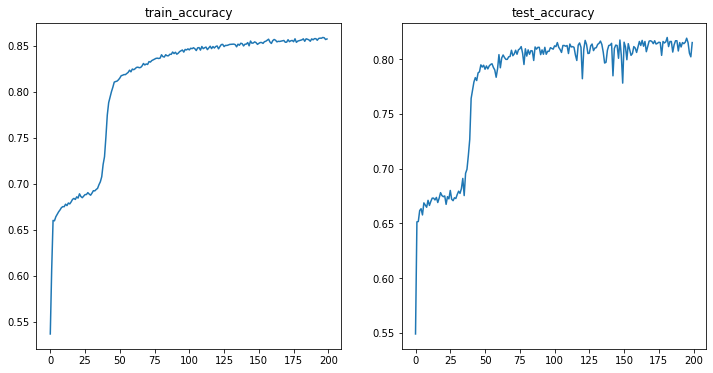

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

train_accuracy = history_info[index].history['accuracy']
test_accuracy = history_info[index].history['val_accuracy']

ax[0].plot(train_accuracy);
ax[1].plot(test_accuracy);

ax[0].set_title('train_accuracy');
ax[1].set_title('test_accuracy');

Estos dos gráficos representa la evolución del ratio de acierto para los conjuntos de entrenamiento y test, respectivamente, a medida que el número de épocas aumenta. En el conjunto de entrenamiento, podemos ver como el acierto del modelo va aumentando a la par que el número de épocas aumenta también.

Por otro lado, en el segundo gráfico podemos ver un comportamiento más normal al que veíamos con la activación *linear* o la *sigmoid*. Se dan picos tanto altos como bajos de ratio de acierto, aún así, como evolución general, se puede observar como para las épocas exploradas, tenemos una evolución que, llegado un punto, va creciendo muy despacio. Es decir, para esta activación y las épocas exploradas, un mayor número de épocas corresponde a un mejor resultado.

Como explicábamos antes, el número de épocas está relacionado también con el problema de over-fitting que se da cuando el número de épocas empieza a ser muy grande. Con la activación *relu* esto parece no estar pasando, quizá si exploraramos más épocas, veríamos como la precisión en el conjunto test empezaría a disminuir.

In [ ]:
relu_epochs = np.argmax(history_info[index].history['val_accuracy'])
relu_epochs

181

El mejor número de época es 181.

In [ ]:
target_names = ["Class {}".format(i) for i in range(3)]

pred = [np.argmax(x) for x in nn.predict(X_test)]
print(classification_report(y_test, pred, target_names=target_names))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.77      0.89      0.83      1000
     Class 1       0.84      0.88      0.86      1000
     Class 2       0.76      0.60      0.67      1000

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.78      3000
weighted avg       0.79      0.79      0.78      3000



Podemos observar que para la función de activación *relu* tenemos aciertos razonablemente buenos. Especialmente respecto a las clases 0 y 1, tenemos aciertos del 0.83 y 0.86 respectivamente. Por otro lado, la clase con la que más se equivoca nuestro modelo es la clase 2.

Hablando en general de nuestro modelo, podemos ver que obtiene un ratio de acierto de aproximadamente un 0.79, este modelo podría ser catalogado como bueno.

## Apartado c

Cuando explicamos los métodos de reducción de dimensionalidad, todos menos uno fueron sin supervisión. El único que es supervisado (el discriminante de Fisher) es lineal. Funciona proyectando los datos a unas pocas dimensiones optimizando su separabilidad. Las redes neuronales son lo suficientemente flexibles como para ayudarnos a obtener una representación de baja dimensionalidad de los datos casi gratis con solo un ajuste de la red. Vamos a insertar una capa densa con dos neuronas entre las dos capas
ocultas para los modelos creados con cada una de las activaciones vistas.

Cada capa de una red neuronal es básicamente una proyección a un espacio con dimensionalidad el número de neuronas de la entrada de la capa. Tal y como veremos a continuación, vamos a proyectar la primera capa oculta a 2D y luego a proyectarla nuevamente a la dimensionalidad de la última capa oculta.

### Linear activation

Vamos a entrenar la red descrita con los mejores parámetros obtenidos para la activación *linear*.

In [ ]:
act = 'linear'

input = keras.Input(shape=(28,28))
model = keras.layers.Flatten()(input)
model = keras.layers.Dense(linear_NN1, activation=act)(model)
rdim = keras.layers.Dense(2, activation=act)(model)
model = keras.layers.Dense(linear_NN2, activation=act)(rdim)
model = keras.layers.Dense(3, activation='softmax')(model)

nn = keras.Model(input, model)
ndim = keras.Model(input, rdim)

# nn network compilation and fit
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']);
nn.fit(X_train, y_train, epochs=linear_epochs, verbose=False);

In [ ]:
pred = [np.argmax(x) for x in nn.predict(X_test)]
print('Accuracy:', np.sum(np.array(pred) == np.array(y_test)) / len(y_test))

94/94 [==============================] - 0s 1ms/step
Accuracy: 0.7976666666666666


Podemos ver como el acierto para este modelo, y con estos parámetros, es muy parecido al que veíamos en el apartado b para esta misma activación.

Vamos a utilizar ahora el modelo adicional, que se entrena al mismo tiempo, para predecir las coordenadas de los datos del test. Las representaremos empleando colores para distinguir las distintas clases.

In [ ]:
coordinates = ndim.predict(X_test)
coordinates

94/94 [==============================] - 0s 1ms/step


array([[-3.8226094 , -1.9864584 ],
       [-3.0520744 , -0.04492882],
       [-2.5643167 , -0.2573729 ],
       ...,
       [-0.8193959 , -1.8553675 ],
       [-3.3051884 ,  0.62277126],
       [ 0.33106902, -0.3017651 ]], dtype=float32)

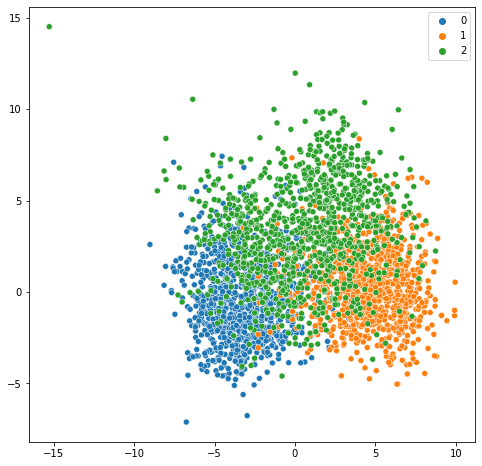

In [ ]:
import seaborn as sns

x = coordinates[:,0]
y = coordinates[:,1]

plt.figure(figsize=(8,8));
sns.scatterplot(x=x, y=y, hue=y_test, palette='tab10');

Podemos ver que existe un separación más clara entre las dos primeras clases. La última clase, a pesar de que también aparece diferenciada, tiende a mezclarse con las otras dos algo más, aparece superpuesta a la clase 0 y la clase 1. Esto concuerda con los resultados obtenidos previamente en el apartado b donde el acierto para la clase 2 era más bajo.

### Sigmoid activation

Vamos a entrenar la red descrita con los mejores parámetros obtenidos para la activación *sigmoid*.

In [ ]:
act = 'sigmoid'

input = keras.Input(shape=(28,28))
model = keras.layers.Flatten()(input)
model = keras.layers.Dense(sigmoid_NN1, activation=act)(model)
rdim = keras.layers.Dense(2, activation=act)(model)
model = keras.layers.Dense(sigmoid_NN2, activation=act)(rdim)
model = keras.layers.Dense(3, activation='softmax')(model)

nn = keras.Model(input, model)
ndim = keras.Model(input, rdim)

# nn network compilation and fit
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']);
nn.fit(X_train, y_train, epochs=sigmoid_epochs, verbose=False);

In [ ]:
pred = [np.argmax(x) for x in nn.predict(X_test)]
print('Accuracy:', np.sum(np.array(pred) == np.array(y_test)) / len(y_test))

94/94 [==============================] - 0s 1ms/step
Accuracy: 0.8276666666666667


Podemos ver como el acierto para este modelo, y con estos parámetros, es muy parecido al que veíamos en el anterior apartado.

In [ ]:
coordinates = ndim.predict(X_test)
coordinates

94/94 [==============================] - 0s 1ms/step


array([[0.08670618, 0.0151738 ],
       [0.3089895 , 0.02000599],
       [0.06497964, 0.01256981],
       ...,
       [0.12938428, 0.09804272],
       [0.31790578, 0.02912955],
       [0.3386755 , 0.30465996]], dtype=float32)

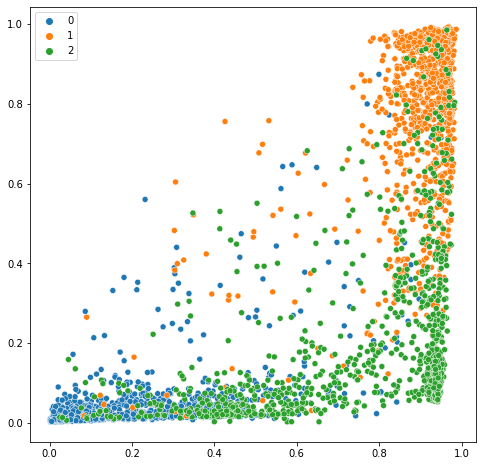

In [ ]:
x = coordinates[:,0]
y = coordinates[:,1]

plt.figure(figsize=(8,8));
sns.scatterplot(x=x, y=y, hue=y_test, palette='tab10');

A pesar de la peculiar representación, podemos ver que existe un separación muy clara entre las dos primeras clases (aparecen muy alejadas entre ellas). La última clase, a pesar de que también aparece diferenciada, tiende a mezclarse con las otras dos algo más, está entre medio de estas. Esto concuerda con los resultados obtenidos previamente en el apartado b, donde para las clase 0 y 1 obteníamos tasas de aciertos más elevadas.

### Relu activation

Vamos a entrenar la red descrita con los mejores parámetros obtenidos para la activación *relu*.

In [ ]:
act = 'relu'

input = keras.Input(shape=(28,28))
model = keras.layers.Flatten()(input)
model = keras.layers.Dense(relu_NN1, activation=act)(model)
rdim = keras.layers.Dense(2, activation=act)(model)
model = keras.layers.Dense(relu_NN2, activation=act)(rdim)
model = keras.layers.Dense(3, activation='softmax')(model)

nn = keras.Model(input, model)
ndim = keras.Model(input, rdim)

# nn network compilation and fit
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']);
nn.fit(X_train, y_train, epochs=relu_epochs, verbose=False);

In [ ]:
pred = [np.argmax(x) for x in nn.predict(X_test)]
print('Accuracy:', np.sum(np.array(pred) == np.array(y_test)) / len(y_test))

94/94 [==============================] - 0s 1ms/step
0.8166666666666667


Podemos ver como el acierto para este modelo, y con estos parámetros, es muy parecido al que veíamos en el anterior apartado.

In [ ]:
coordinates = ndim.predict(X_test)
coordinates

94/94 [==============================] - 0s 1ms/step


array([[0.09613702, 0.18753071],
       [0.21237205, 0.25294033],
       [0.15150894, 0.11962406],
       ...,
       [0.        , 0.        ],
       [0.21017672, 0.29362094],
       [0.        , 0.        ]], dtype=float32)

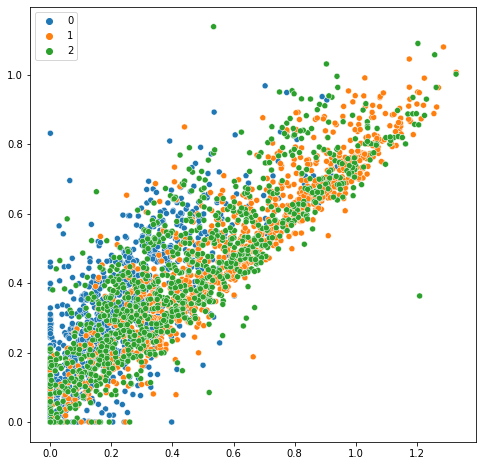

In [ ]:
x = coordinates[:,0]
y = coordinates[:,1]

plt.figure(figsize=(8,8));
sns.scatterplot(x=x, y=y, hue=y_test, palette='tab10');

A pesar de la peculiar representación, podemos ver que existe una separación entre las dos primeras clases. La última clase, aparece superpuesta a las otras dos y parece que, con más dimensiones quizá sería más fácil ver la separación de clases. A pesar de todo, esto también concuerda con los resultados obtenidos previamente en el apartado b, en los que la clase 2, tiene tasas de acierto algo peores.

### PCA

Ahora vamos a calcular el PCA y comparar este resultado con los obtenidos para cada una de las activaciones. Previamente vamos a modificar la matriz para que pueda ser utilizada por las funciones de pca.

In [ ]:
from sklearn.decomposition import PCA

nsamples, nx, ny = X_train.shape
X_train_reshape = X_train.reshape((nsamples,nx*ny))

X_pca = PCA().fit(X_train_reshape);

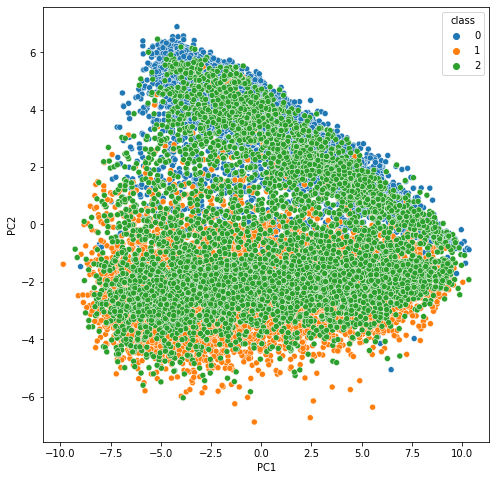

In [ ]:
X_pca = X_pca.transform(X_train_reshape)
data = pd.DataFrame({'PC1':X_pca[:,0], 'PC2':X_pca[:,1], 'PC3':X_pca[:,2], 'class':y_train})
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=data, palette='tab10');

Utilizando pca podemos ver un comportamiento similiar al que nos hemos ido encontrado. Las dos primeras clases se separan de forma clara, de ahí que nuestros modelos tengan buenos aciertos en dichas clases. Con la última clase en cambio, aparece sobrepuesta a las otras dos, probablemente con más dimensiones esta clase también sería separable. Estos datos tienen relación a las tasas de acierto obtenidas para las distintas clases en el apartado b.

Aún así, el mejor resultado de separación lo hemos obtenido con la activación *linear* a través de la representación de las coordenadas.

En clase explicamos un método de reducción de dimensionalidad no lineal que podemos utilizar en este apartado, t-Distributed Stochastic Neighbor Embedding (t-SNE). Esta nos permite  usar la transformación que obtenemos de los datos de entrenamiento para aplicarla a los datos de test. Vamos a ajustar una transformación 2D con ese método empleando una muestra del 20 % de los datos de entrenamiento y a aplicarla a los datos de test Representad el resultado.

In [ ]:
from re import X
import random

X_train_20 = random.sample(list(X_train_reshape), len(X_train_reshape * 0.2))

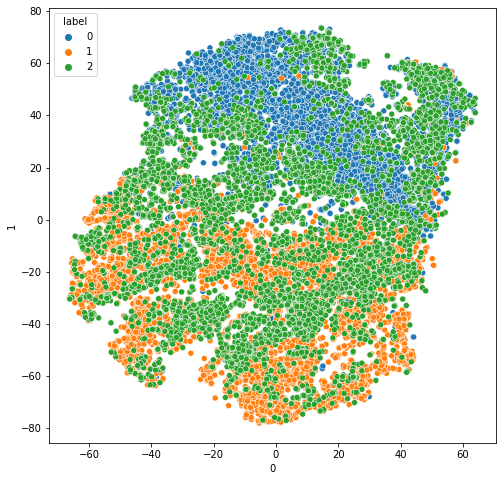

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(init='pca')
tdata = tsne.fit_transform(X_train_reshape)
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]),pd.DataFrame({'label':y_train})],axis=1);
fig = plt.figure(figsize=(8,8));
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');

Comparando esta representación de la separación de clases respecto a las otras vistas, podemos confirmar que esta es mejor. t-SNE es un método no lineal lo que permite separaciones como las que vemos en la imagen lo que, en algunos casos, puede ser de gran ayuda sobretodo cuando los datos no son lineales. Es especialmente útil, y está pensado también, para que se utilice cuando se trabaja con redes neuronales como es nuestro caso en este ejercicio.

Suena lógico entonces que el uso de un método de t-SNE nos de mejores resultados que otros métodos de reducción de dimensionalidad. Nuestros datos no son linealmente separables y además estamos trabajando con modelos que utilizan redes neuronales.